In [1]:
pip install patchify

Note: you may need to restart the kernel to use updated packages.


In [2]:

import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.metrics import MeanIoU
import random

2024-08-31 15:49:41.139491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
image = tiff.imread('AerialImageDataset/train/images/austin1.tif')
imagemask = tiff.imread('AerialImageDataset/train/gt/austin1.tif')
image2 = tiff.imread('AerialImageDataset/train/images/vienna36.tif')
imagemask2 = tiff.imread('AerialImageDataset/train/gt/vienna36.tif')
print(image.shape)
print(imagemask.shape)


(5000, 5000, 3)
(5000, 5000)


In [5]:

unique_labels, counts = np.unique(imagemask, return_counts=True)


for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} pixels")

Label 0: 21311242 pixels
Label 255: 3688758 pixels


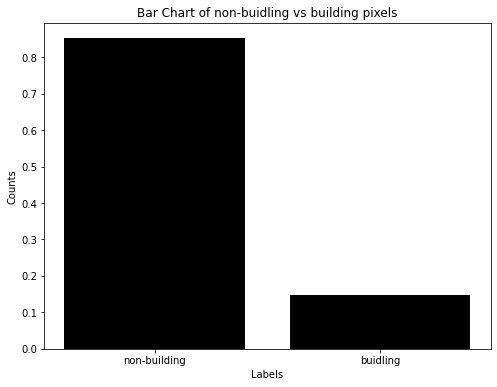

In [6]:

count = counts / counts.sum()
plt.figure(figsize=(8, 6))
plt.bar(['non-building',"buidling"], count, color='black')  
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Bar Chart of non-buidling vs building pixels')
plt.xticks(['non-building',"buidling"])  
plt.show()

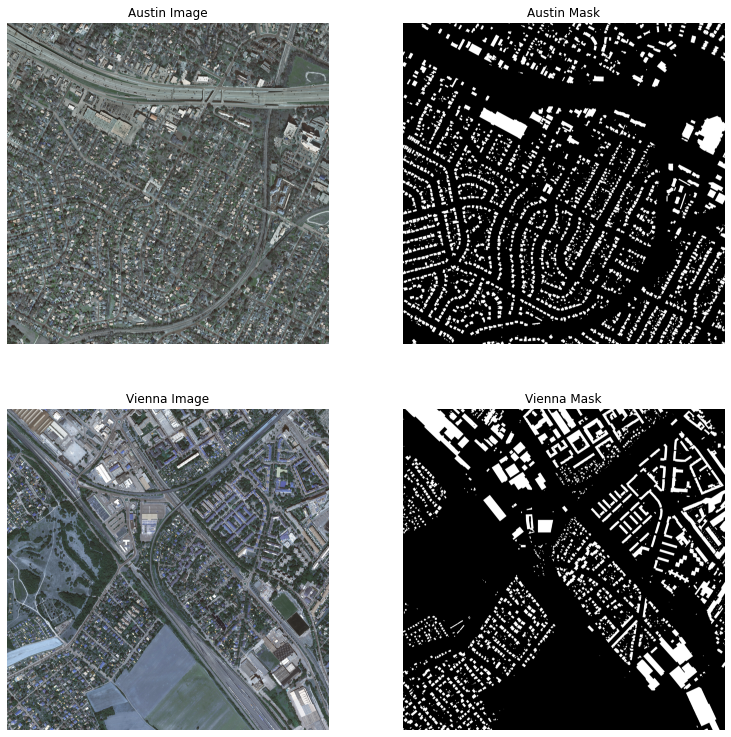

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13))

axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Austin Image')
axs[0, 0].axis('off')  


axs[0, 1].imshow(cv2.cvtColor(imagemask, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Austin Mask')
axs[0, 1].axis('off') 


axs[1, 0].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Vienna Image')
axs[1, 0].axis('off')  


axs[1, 1].imshow(cv2.cvtColor(imagemask2, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Vienna Mask')
axs[1, 1].axis('off')  

plt.show()

In [9]:
#patchifying images into patches of 256x256
directory = 'AerialImageDataset/train/'
patch_size = 256

imageDirectory = os.path.join(directory, "images")
outputDirectory = os.path.join("256_patches", "images")


# Check if the output directory exists
if not os.path.exists(outputDirectory):
    os.makedirs(outputDirectory)
    

    for path, subdirs, files in os.walk(imageDirectory):

        images = os.listdir(path)  

        for i, image_name in enumerate(images):  
            image = cv2.imread(os.path.join(path, image_name), 1)

            #calculating the Nearest size divisible by the patch size
            SIZE_X = (image.shape[1]//patch_size)*patch_size 
            SIZE_Y = (image.shape[0]//patch_size)*patch_size 
            image = Image.fromarray(image)
            #cropping image 
            image = image.crop((0 ,0, SIZE_X, SIZE_Y)) 
            #saving to numpy array    
            image = np.array(image)             

            #Extract patches from eimage
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):

                    single_patch_img = patches_img[i,j,:,:]

                    single_patch_img = single_patch_img[0]


                    output_file_path = os.path.join(outputDirectory,f"{image_name}_patch_{i}_{j}.tif")
                    cv2.imwrite(output_file_path, single_patch_img)


    print('Finished')
    
else:
    print("image already patchified")

Now patchifying image: AerialImageDataset/train/images/chicago6.tif
Now patchifying image: AerialImageDataset/train/images/vienna16.tif
Now patchifying image: AerialImageDataset/train/images/vienna17.tif
Now patchifying image: AerialImageDataset/train/images/chicago7.tif
Now patchifying image: AerialImageDataset/train/images/chicago5.tif
Now patchifying image: AerialImageDataset/train/images/vienna29.tif
Now patchifying image: AerialImageDataset/train/images/vienna15.tif
Now patchifying image: AerialImageDataset/train/images/vienna14.tif
Now patchifying image: AerialImageDataset/train/images/vienna28.tif
Now patchifying image: AerialImageDataset/train/images/chicago4.tif
Now patchifying image: AerialImageDataset/train/images/vienna10.tif
Now patchifying image: AerialImageDataset/train/images/vienna11.tif
Now patchifying image: AerialImageDataset/train/images/chicago1.tif
Now patchifying image: AerialImageDataset/train/images/chicago3.tif
Now patchifying image: AerialImageDataset/train/

Now patchifying image: AerialImageDataset/train/images/tyrol-w13.tif
Now patchifying image: AerialImageDataset/train/images/kitsap18.tif
Now patchifying image: AerialImageDataset/train/images/kitsap5.tif
Now patchifying image: AerialImageDataset/train/images/kitsap24.tif
Now patchifying image: AerialImageDataset/train/images/kitsap30.tif
Now patchifying image: AerialImageDataset/train/images/austin7.tif
Now patchifying image: AerialImageDataset/train/images/chicago19.tif
Now patchifying image: AerialImageDataset/train/images/chicago31.tif
Now patchifying image: AerialImageDataset/train/images/chicago25.tif
Now patchifying image: AerialImageDataset/train/images/chicago24.tif
Now patchifying image: AerialImageDataset/train/images/chicago30.tif
Now patchifying image: AerialImageDataset/train/images/chicago18.tif
Now patchifying image: AerialImageDataset/train/images/austin6.tif
Now patchifying image: AerialImageDataset/train/images/kitsap31.tif
Now patchifying image: AerialImageDataset/tr

In [10]:
#patchifying masks into patches of 256x256
imageDirectory = os.path.join(directory, "gt")
outputDirectory = os.path.join( "256_patches", "gt")

# Check if the output directory exists
if not os.path.exists(outputDirectory):
    os.makedirs(outputDirectory)
    
    for path, subdirs, files in os.walk(imageDirectory):
        images = os.listdir(path)  

        for i, image_name in enumerate(images):  
            # Read the mask as grayscale
            image = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)

            # Calculate the nearest size divisible by the patch size
            SIZE_X = (image.shape[1] // patch_size) * patch_size 
            SIZE_Y = (image.shape[0] // patch_size) * patch_size 
            
            # Crop the mask to the nearest size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y)) 
            
            # Convert back to numpy array
            image = np.array(image)

            
            image = np.expand_dims(image, axis=-1)

            # Extract patches from the mask
            print("Now patchifying image:", os.path.join(path, image_name))
            patches_img = patchify(image, (256, 256, 1), step=256)  

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i, j, 0]  

                    # Save the patch
                    output_file_path = os.path.join(outputDirectory, f"{image_name}_patch_{i}_{j}.tif")
                    cv2.imwrite(output_file_path, single_patch_img)

    print('Finished')

else:
    print("Images already patchified") 

Now patchifying image: AerialImageDataset/train/gt/chicago6.tif
Now patchifying image: AerialImageDataset/train/gt/vienna16.tif
Now patchifying image: AerialImageDataset/train/gt/vienna17.tif
Now patchifying image: AerialImageDataset/train/gt/chicago7.tif
Now patchifying image: AerialImageDataset/train/gt/chicago5.tif
Now patchifying image: AerialImageDataset/train/gt/vienna29.tif
Now patchifying image: AerialImageDataset/train/gt/vienna15.tif
Now patchifying image: AerialImageDataset/train/gt/vienna14.tif
Now patchifying image: AerialImageDataset/train/gt/vienna28.tif
Now patchifying image: AerialImageDataset/train/gt/chicago4.tif
Now patchifying image: AerialImageDataset/train/gt/vienna10.tif
Now patchifying image: AerialImageDataset/train/gt/vienna11.tif
Now patchifying image: AerialImageDataset/train/gt/chicago1.tif
Now patchifying image: AerialImageDataset/train/gt/chicago3.tif
Now patchifying image: AerialImageDataset/train/gt/vienna13.tif
Now patchifying image: AerialImageDatase

Now patchifying image: AerialImageDataset/train/gt/chicago31.tif
Now patchifying image: AerialImageDataset/train/gt/chicago25.tif
Now patchifying image: AerialImageDataset/train/gt/chicago24.tif
Now patchifying image: AerialImageDataset/train/gt/chicago30.tif
Now patchifying image: AerialImageDataset/train/gt/chicago18.tif
Now patchifying image: AerialImageDataset/train/gt/austin6.tif
Now patchifying image: AerialImageDataset/train/gt/kitsap31.tif
Now patchifying image: AerialImageDataset/train/gt/kitsap25.tif
Now patchifying image: AerialImageDataset/train/gt/kitsap4.tif
Now patchifying image: AerialImageDataset/train/gt/tyrol-w12.tif
Now patchifying image: AerialImageDataset/train/gt/kitsap19.tif
Now patchifying image: AerialImageDataset/train/gt/austin22.tif
Now patchifying image: AerialImageDataset/train/gt/austin36.tif
Now patchifying image: AerialImageDataset/train/gt/austin20.tif
Now patchifying image: AerialImageDataset/train/gt/austin34.tif
Now patchifying image: AerialImageDa

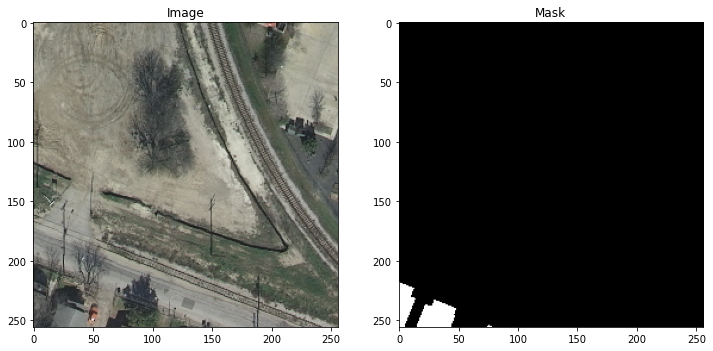

In [12]:



train_img_dir = "256_patches/images/"
train_mask_dir = "256_patches/gt/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [16]:
pip install --upgrade opencv-python


  Using cached opencv-python-4.10.0.84.tar.gz (95.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
anceled
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [17]:
#calulating mask with atleast 5% useful pixel and discarding the rest 
train_img_dir = "256_patches/images/"
train_mask_dir = "256_patches/gt/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

outputDirectoryF= os.path.join("images_with_useful_info")



# Check if the output directory exists
if not os.path.exists(outputDirectoryF):
    
    
    outputDirectoryForMasks = os.path.join(outputDirectoryF, "masks")

    outputDirectoryForImages = os.path.join(outputDirectoryF, "images")

    os.makedirs(outputDirectoryForMasks)
    os.makedirs(outputDirectoryForImages)


    useless=0  
    for img in range(len(img_list)):   
        img_name=img_list[img]
        mask_name = msk_list[img]
        


        
        temp_image = cv2.imread(os.path.join(train_img_dir, img_name), cv2.IMREAD_COLOR)
        temp_mask = cv2.imread(os.path.join(train_mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
    
        val, counts = np.unique(temp_mask, return_counts=True)

        if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0

           
            
            image_output_file_path = os.path.join(outputDirectoryForImages, img_name)
            tiff.imwrite(image_output_file_path, temp_image)

            mask_output_file_path = os.path.join(outputDirectoryForMasks, mask_name)
            tiff.imwrite(mask_output_file_path, temp_mask)




        else:
          
            useless +=1

    print("Total useful images are: ", len(img_list)-useless)  
    print("Total useless images are: ", useless) 
else:
    print("images_with_useful_info_ directory created already")

Total useful images are:  37066
Total useless images are:  27914


In [18]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os


All images and masks match in train.
All images and masks match in val.
All images and masks match in test.


In [ ]:
#current directory structure:
dataset/
    train/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....
    val/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....
    test/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....

 #target directory structure            
Data/
    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                

    val_masks/
                val/
                    msk1, msk, msk3, ......
    test_images/
                test/
                    img1, img2, img3, ......                

    test_masks/
                test/
                    msk1, msk, msk3, ......
             
            

In [27]:
import splitfolders 
input_folder = 'images_with_useful_info/'
output_folder = 'dataset/'




splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8,.1,.1), group_prefix=None)




Copying files: 0 files [00:00, ? files/s]

Copying files: 1 files [00:00,  1.07 files/s]

Copying files: 72 files [00:01, 95.17 files/s]

Copying files: 136 files [00:01, 181.92 files/s]

Copying files: 198 files [00:01, 262.60 files/s]

Copying files: 270 files [00:01, 357.45 files/s]

Copying files: 342 files [00:01, 440.58 files/s]

Copying files: 416 files [00:01, 514.09 files/s]

Copying files: 484 files [00:01, 518.37 files/s]

Copying files: 554 files [00:01, 565.06 files/s]

Copying files: 622 files [00:01, 595.89 files/s]

Copying files: 692 files [00:01, 624.15 files/s]

Copying files: 761 files [00:02, 642.56 files/s]

Copying files: 831 files [00:02, 657.88 files/s]

Copying files: 908 files [00:02, 690.30 files/s]

Copying files: 979 files [00:02, 694.84 files/s]

Copying files: 1053 files [00:02, 704.85 files/s]

Copying files: 1125 files [00:02, 699.79 files/s]

Copying files: 1196 files [00:02, 699.67 files/s]

Copying files: 1267 files [00:02, 676.74 files/s]

Copyin

Copying files: 21107 files [00:30, 686.70 files/s]

Copying files: 21177 files [00:30, 684.61 files/s]

Copying files: 21246 files [00:30, 666.44 files/s]

Copying files: 21322 files [00:30, 691.32 files/s]

Copying files: 21392 files [00:31, 682.42 files/s]

Copying files: 21461 files [00:31, 666.59 files/s]

Copying files: 21539 files [00:31, 698.30 files/s]

Copying files: 21618 files [00:31, 724.11 files/s]

Copying files: 21691 files [00:31, 715.60 files/s]

Copying files: 21763 files [00:31, 693.06 files/s]

Copying files: 21841 files [00:31, 714.91 files/s]

Copying files: 21913 files [00:31, 707.52 files/s]

Copying files: 21984 files [00:31, 680.60 files/s]

Copying files: 22066 files [00:32, 718.35 files/s]

Copying files: 22139 files [00:32, 700.05 files/s]

Copying files: 22210 files [00:32, 675.13 files/s]

Copying files: 22281 files [00:32, 684.10 files/s]

Copying files: 22350 files [00:32, 662.86 files/s]

Copying files: 22432 files [00:32, 705.34 files/s]

Copying file

Copying files: 44096 files [01:01, 1011.98 files/s]

Copying files: 44200 files [01:01, 1020.24 files/s]

Copying files: 44303 files [01:01, 1020.78 files/s]

Copying files: 44406 files [01:01, 1020.29 files/s]

Copying files: 44510 files [01:01, 1023.38 files/s]

Copying files: 44613 files [01:01, 1017.16 files/s]

Copying files: 44715 files [01:01, 980.42 files/s] 

Copying files: 44814 files [01:01, 978.29 files/s]

Copying files: 44917 files [01:01, 992.57 files/s]

Copying files: 45017 files [01:01, 991.71 files/s]

Copying files: 45117 files [01:02, 989.52 files/s]

Copying files: 45220 files [01:02, 1000.14 files/s]

Copying files: 45324 files [01:02, 1011.73 files/s]

Copying files: 45427 files [01:02, 1015.80 files/s]

Copying files: 45530 files [01:02, 1017.07 files/s]

Copying files: 45632 files [01:02, 948.38 files/s] 

Copying files: 45737 files [01:02, 976.25 files/s]

Copying files: 45843 files [01:02, 998.89 files/s]

Copying files: 45950 files [01:02, 1018.80 files/s]


Copying files: 72997 files [01:29, 980.18 files/s]

Copying files: 73098 files [01:29, 987.72 files/s]

Copying files: 73198 files [01:29, 991.21 files/s]

Copying files: 73301 files [01:30, 1002.46 files/s]

Copying files: 73402 files [01:30, 997.75 files/s] 

Copying files: 73506 files [01:30, 1010.07 files/s]

Copying files: 73609 files [01:30, 1014.77 files/s]

Copying files: 73711 files [01:30, 983.67 files/s] 

Copying files: 73810 files [01:30, 985.26 files/s]

Copying files: 73909 files [01:30, 896.87 files/s]

Copying files: 74008 files [01:30, 921.71 files/s]

Copying files: 74132 files [01:30, 815.25 files/s]


In [28]:
import shutil
current_folder = 'dataset'

#splting images into target directory structure 
new_folder = 'Data'


os.makedirs(os.path.join(new_folder, 'train_images/train'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'train_masks/train'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'val_images/val'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'val_masks/val'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'test_images/test'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'test_masks/test'), exist_ok=True)


for image in os.listdir(os.path.join(current_folder, 'train/images')):
    shutil.move(os.path.join(current_folder, 'train/images', image),
                os.path.join(new_folder, 'train_images/train', image))


for mask in os.listdir(os.path.join(current_folder, 'train/masks')):
    shutil.move(os.path.join(current_folder, 'train/masks',mask),
                os.path.join(new_folder, 'train_masks/train', mask))


for image in os.listdir(os.path.join(current_folder, 'val/images')):
    shutil.move(os.path.join(current_folder, 'val/images', image),
                os.path.join(new_folder, 'val_images/val', image))

for  mask in os.listdir(os.path.join(current_folder, 'val/masks')):
    shutil.move(os.path.join(current_folder, 'val/masks', mask),
                os.path.join(new_folder, 'val_masks/val', mask))


for image in os.listdir(os.path.join(current_folder, 'test/images')):
    shutil.move(os.path.join(current_folder, 'test/images', image),
                os.path.join(new_folder, 'test_images/test', image))


for mask in os.listdir(os.path.join(current_folder, 'test/masks')):
    shutil.move(os.path.join(current_folder, 'test/masks', mask),
                os.path.join(new_folder, 'test_masks/test', mask))
print('done')

done
